# 0.0 Imports

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import pickle
import warnings
warnings.filterwarnings("ignore")

## 0.1. Funções Auxiliares

In [3]:
#Função que mostra valores nulos
def show_null(df):
    null_columns = (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False).index
    
    null_data = pd.concat([df.isnull().sum(axis=0), 
                           (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False), 
                           df.loc[:, df.columns.isin(list(null_columns))].dtypes], 
                          axis=1)
    
    null_data = null_data.rename(columns={0: '#', 
                                          1: '% null', 
                                          2: 'type'}).sort_values(ascending=False, 
                                                                  by='% null')
    
    return null_data

#============================================================================================
#função para plotar boxplot e stripplot de variaveis numéricas
def plot_num(df, feature):
    fig = plt.figure(figsize=(12,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=feature, data=df, color='firebrick', ax=fig.add_subplot(gs[0,0]))
    plt.ylabel(feature)
    sns.stripplot(y=df[feature], color='darkcyan', ax=fig.add_subplot(gs[0,1]))
    plt.ylabel(None)
    plt.show()

#===========================================================================================
#função para plotar boxplot e stripplot de variaveis categoricas
def plot_cat(df, feature):
    fig = plt.figure(figsize=(12,8))
    ax = sns.countplot(data=df, x=feature)
    for p in ax.patches:
        
        ax.annotate(f'\n{p.get_height()}', 
                    (p.get_x()+0.4, p.get_height()+5), 
                    ha='center', 
                    color='black')
        
    plt.xlabel('\n' + feature)
    plt.ylabel('Quantidade de Clientes')
    plt.show()

# 1.0 Load Data

In [4]:
df = pd.read_csv('marketing_campaign.csv', delimiter='\t')

# 2.0 Explorando Dados

## 2.1 People

In [5]:
# Separa feature relacionadas a pessoas
people = df[['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 
             'Recency', 'Complain']]

In [6]:
people.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Complain
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,0
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,0


In [7]:
#Identifica valores nulos no df People
show_null(people)

,#,% null,type
Income,24,0.010714,float64
ID,0,0.000000,int64
Year_Birth,0,0.000000,int64
Education,0,0.000000,object
Marital_Status,0,0.000000,object
Kidhome,0,0.000000,int64
Teenhome,0,0.000000,int64
Dt_Customer,0,0.000000,object
Recency,0,0.000000,int64
Complain,0,0.000000,int64


### 2.1.1 Income

In [8]:
people.dropna(inplace=True)

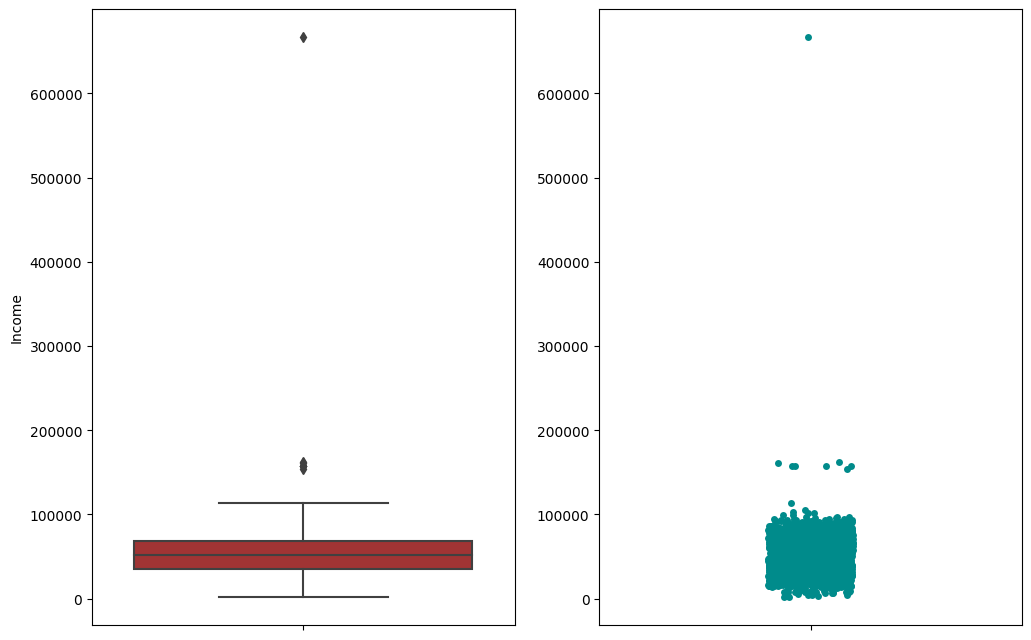

In [9]:
plot_num(people, 'Income')

In [10]:
# recortando df para tirar outliers
people = people[people.Income < 200000]

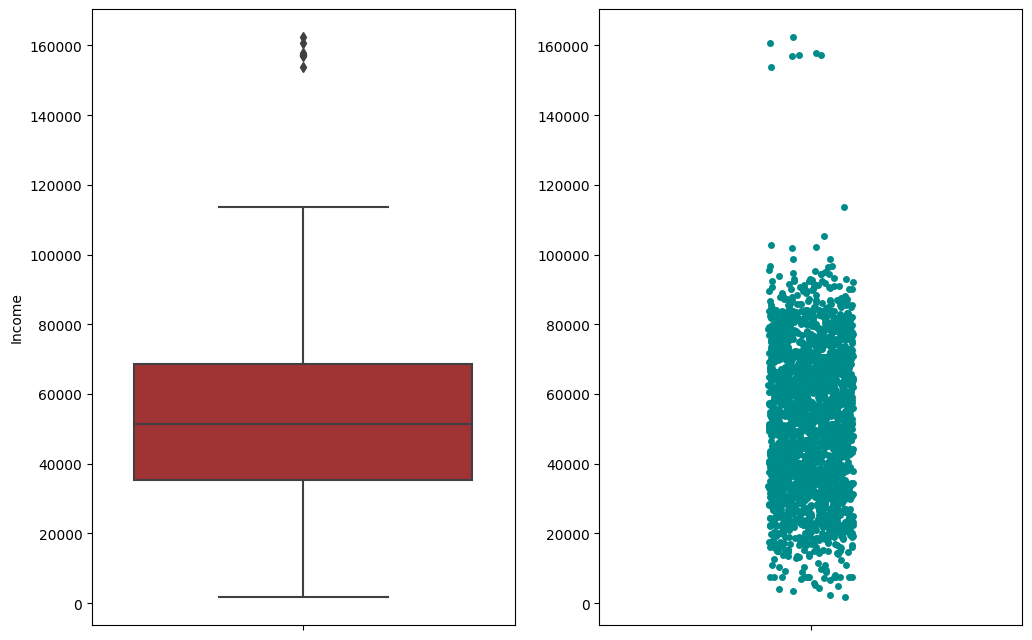

In [11]:
plot_num(people, 'Income')

### 2.1.2 Year_Birth

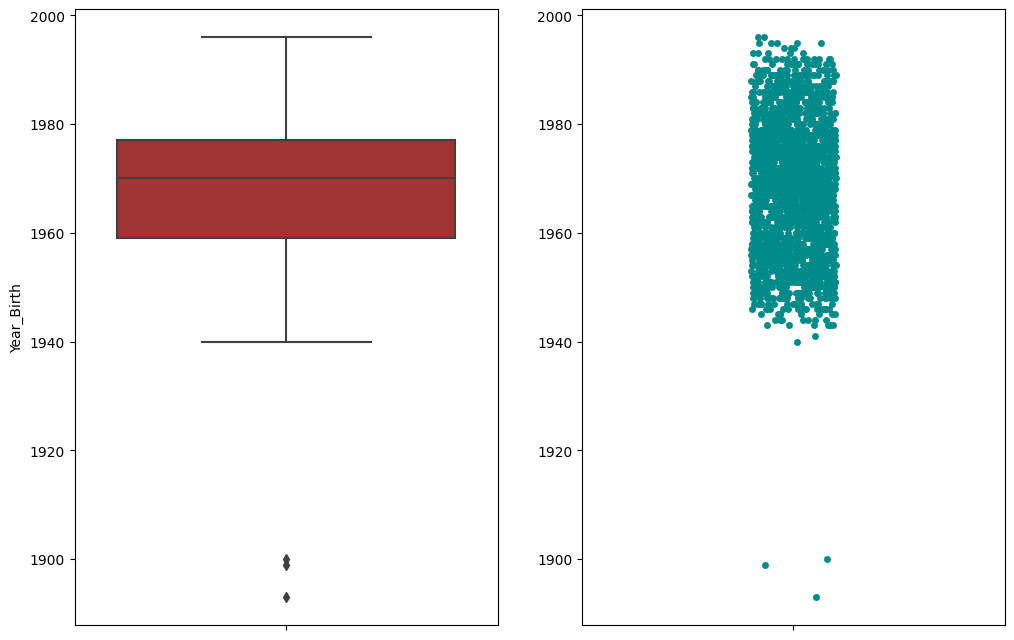

In [12]:
plot_num(people, 'Year_Birth')

In [13]:
people = people[people.Year_Birth > 1930]

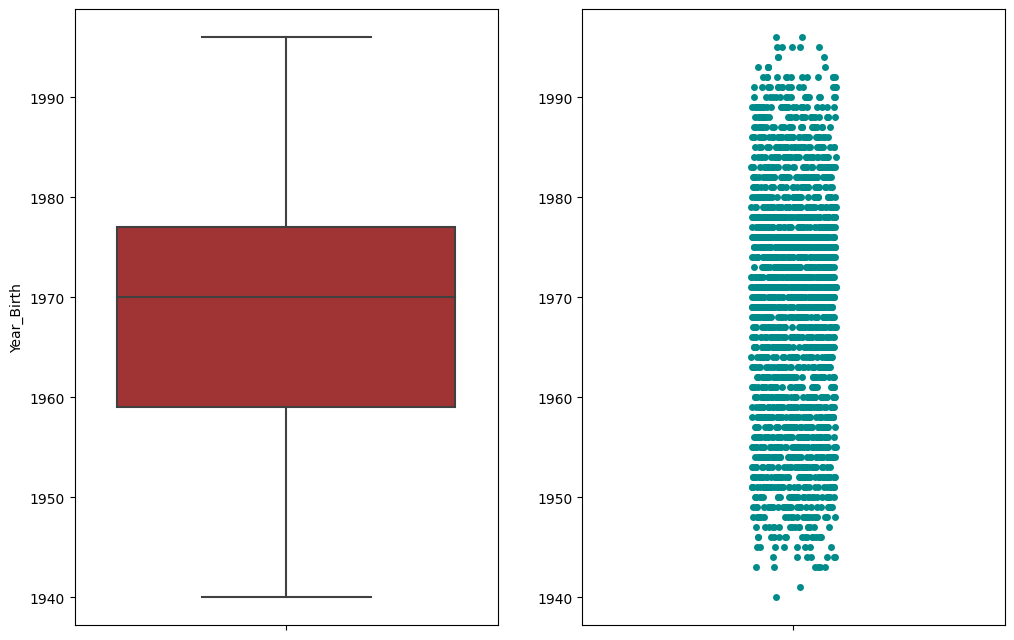

In [14]:
plot_num(people, 'Year_Birth')

### 2.1.3 Education

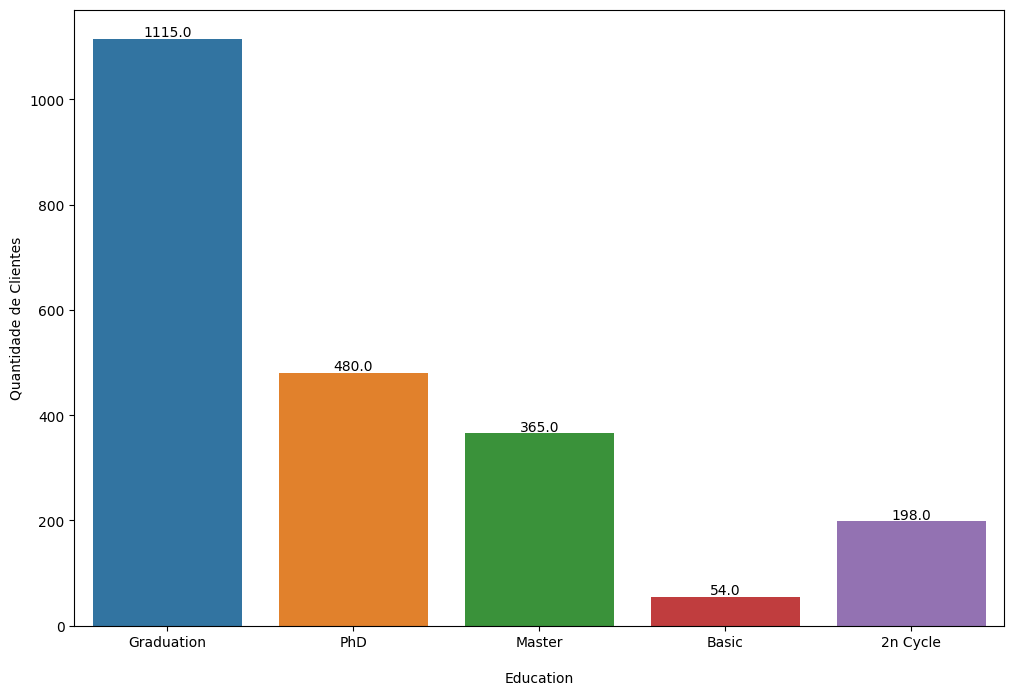

In [15]:
plot_cat(people, 'Education')

In [16]:
#Substitui nomes por números
people.Education = people.Education.apply(lambda x: 0 if x=='Basic' 
                       else(1 if x=='2n Cycle' 
                            else(2 if x=='Graduation' 
                                 else(3 if x =='Master' 
                                      else(4 if x=='PhD' else None)))))

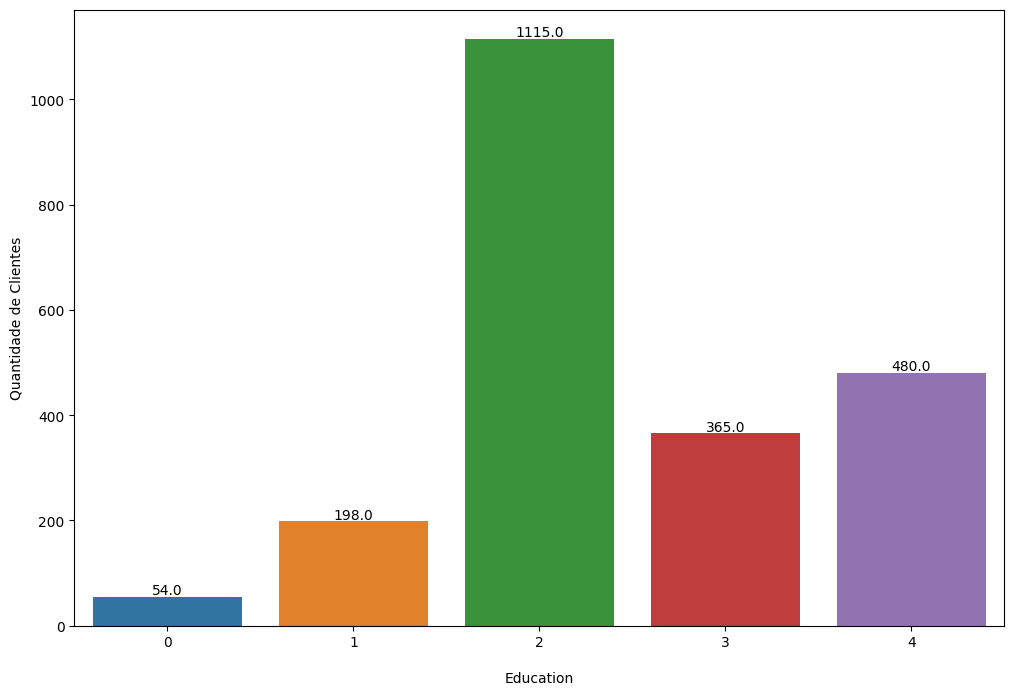

In [17]:
plot_cat(people, 'Education')

### 2.1.4 Marital_Status

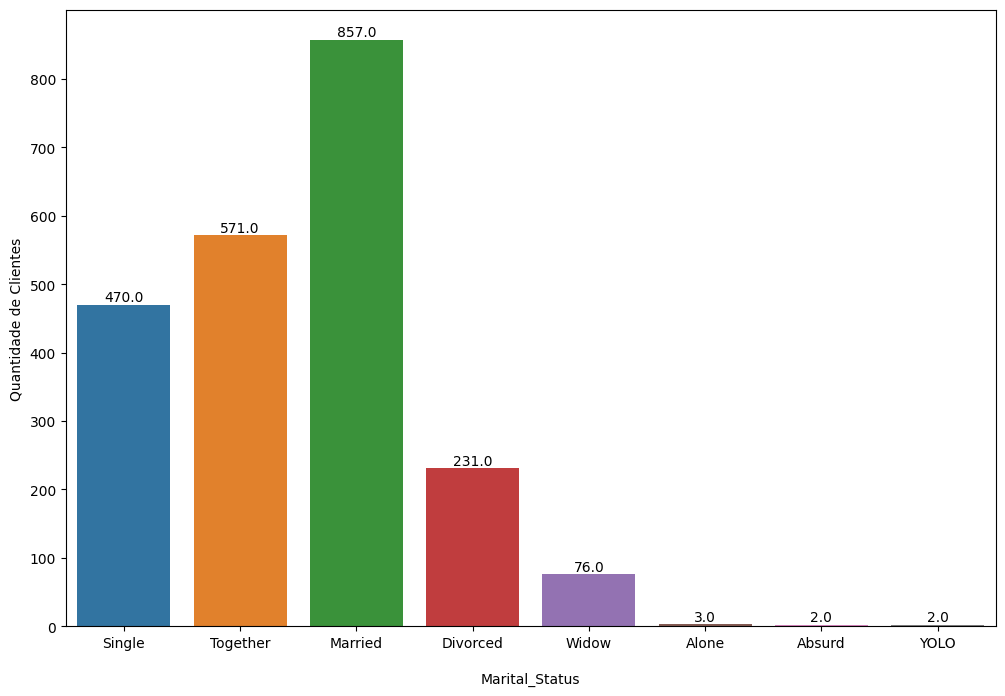

In [18]:
plot_cat(people, 'Marital_Status')

In [19]:
people = people[people.Marital_Status != 'Absurd']

In [20]:
#Agrupa "alone" e "YOLO" em single
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Single' if x=='Alone' 
                                                    else('Single' if x =='YOLO' else x))

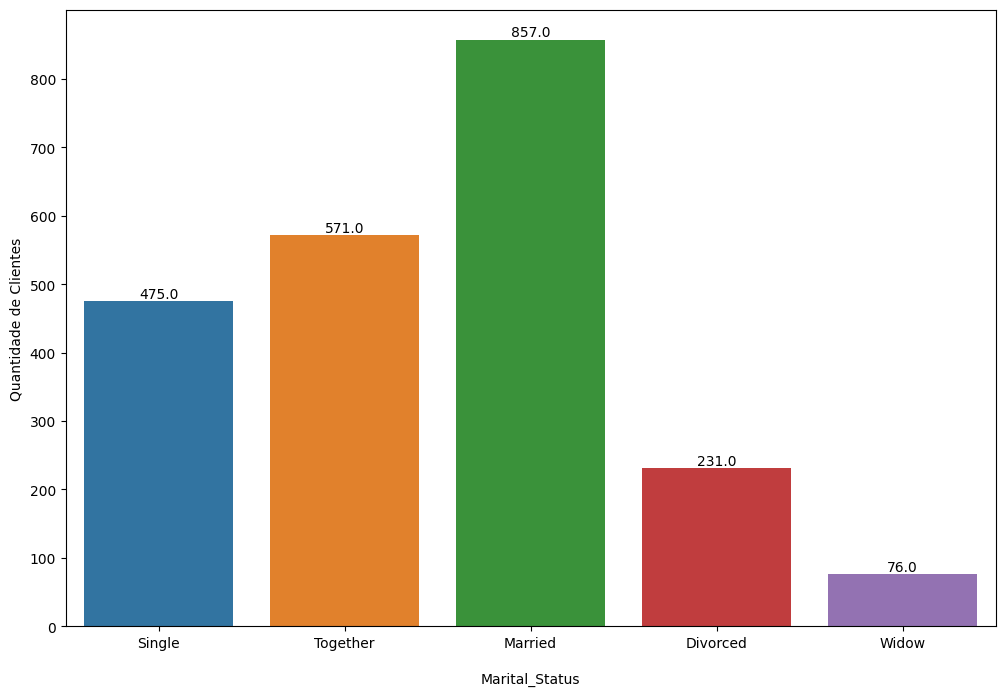

In [21]:
plot_cat(people, 'Marital_Status')

In [22]:
#Agrupando "Together" em Married
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Together' if x=='Married' else x)

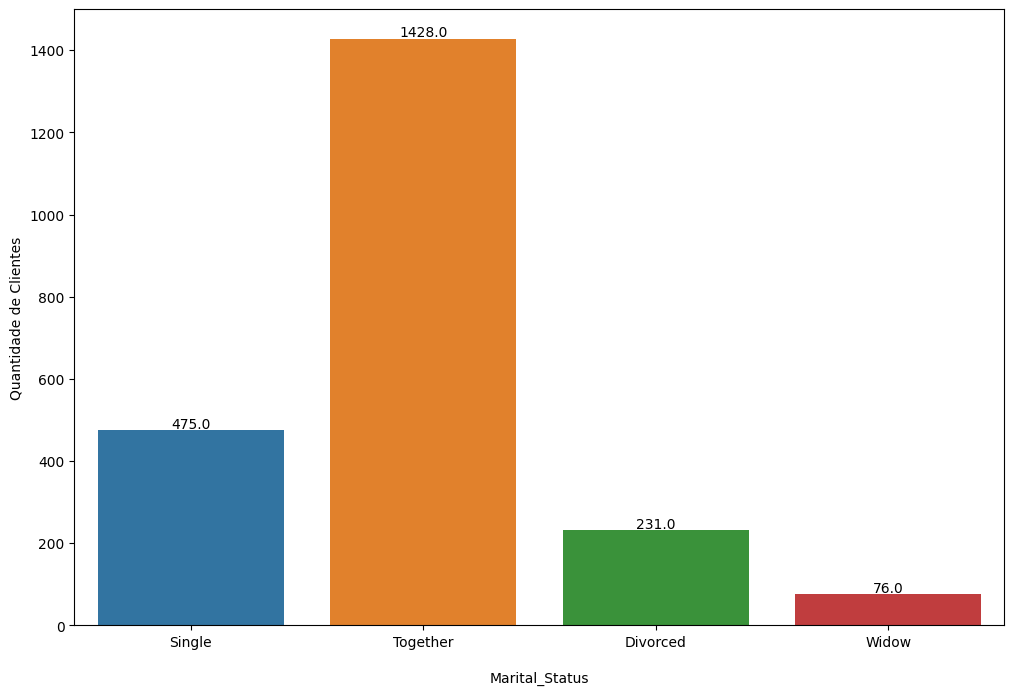

In [23]:
plot_cat(people, 'Marital_Status')

In [24]:
people.dtypes

ID                  int64
Year_Birth          int64
Education           int64
Marital_Status     object
Income            float64
Kidhome             int64
Teenhome            int64
Dt_Customer        object
Recency             int64
Complain            int64
dtype: object

In [25]:
people.Dt_Customer = pd.to_datetime(people.Dt_Customer, dayfirst=True)

In [26]:
people = pd.get_dummies(people)

In [27]:
people

,ID,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,Complain,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,5524,1957,2,58138.0,0,0,2012-09-04,58,0,0,1,0,0
1,2174,1954,2,46344.0,1,1,2014-03-08,38,0,0,1,0,0
2,4141,1965,2,71613.0,0,0,2013-08-21,26,0,0,0,1,0
3,6182,1984,2,26646.0,1,0,2014-02-10,26,0,0,0,1,0
4,5324,1981,4,58293.0,1,0,2014-01-19,94,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,2,61223.0,0,1,2013-06-13,46,0,0,0,1,0
2236,4001,1946,4,64014.0,2,1,2014-06-10,56,0,0,0,1,0
2237,7270,1981,2,56981.0,0,0,2014-01-25,91,0,1,0,0,0
2238,8235,1956,3,69245.0,0,1,2014-01-24,8,0,0,0,1,0


### 2.1.5 Kidhome

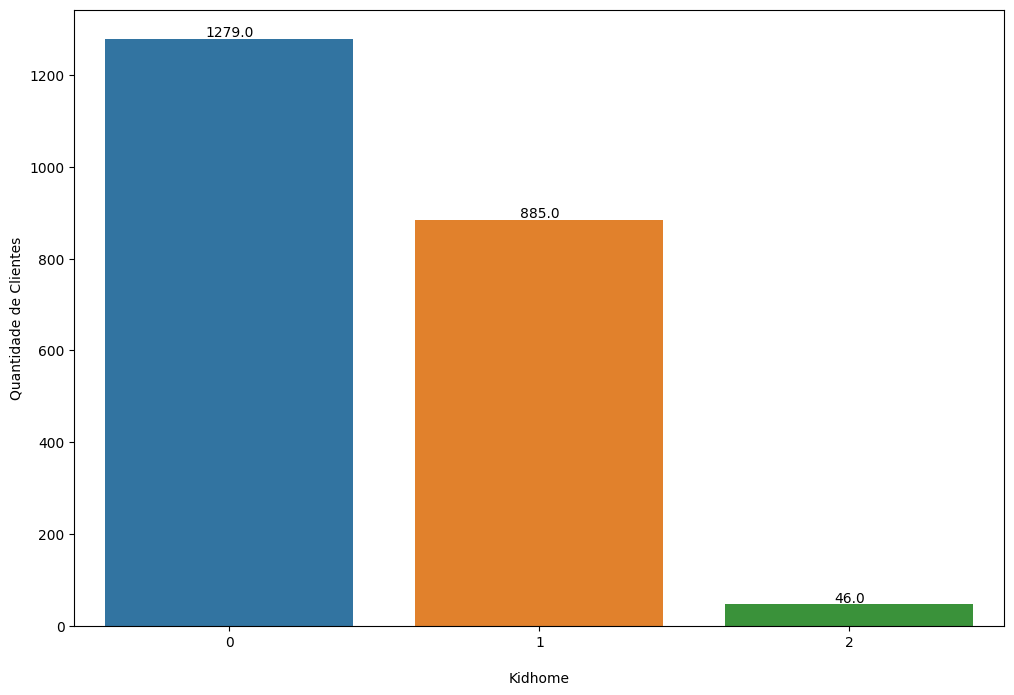

In [28]:
plot_cat(people, 'Kidhome')

### 2.1.6 TeenHome

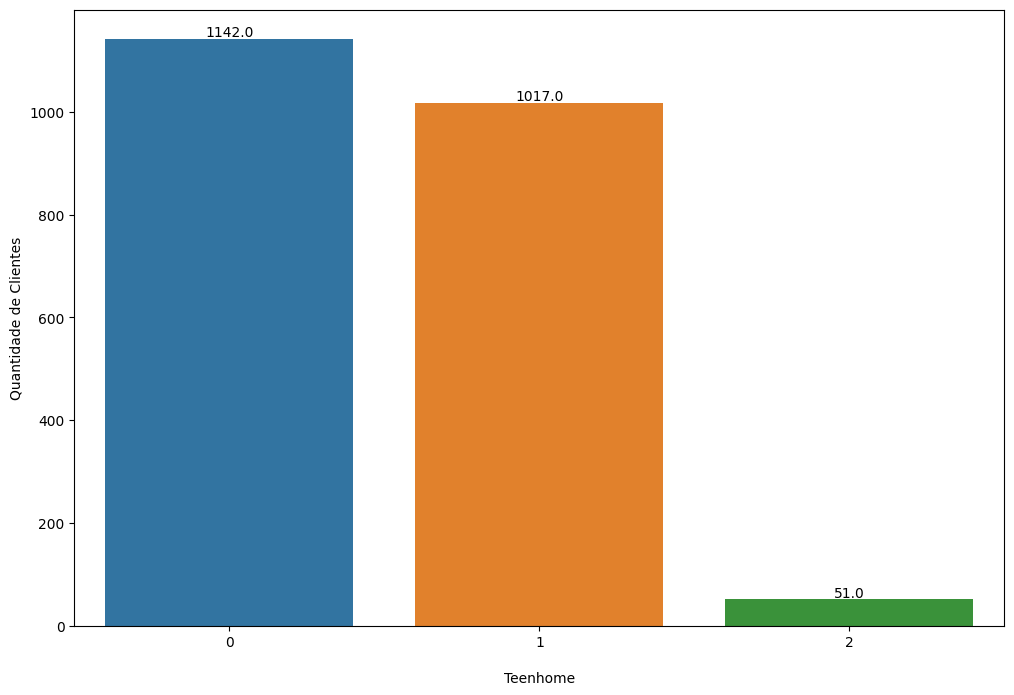

In [29]:
plot_cat(people, 'Teenhome')

### 2.1.7 ChildrenHome

In [30]:
people['ChildrenHome'] = people.Kidhome + people.Teenhome

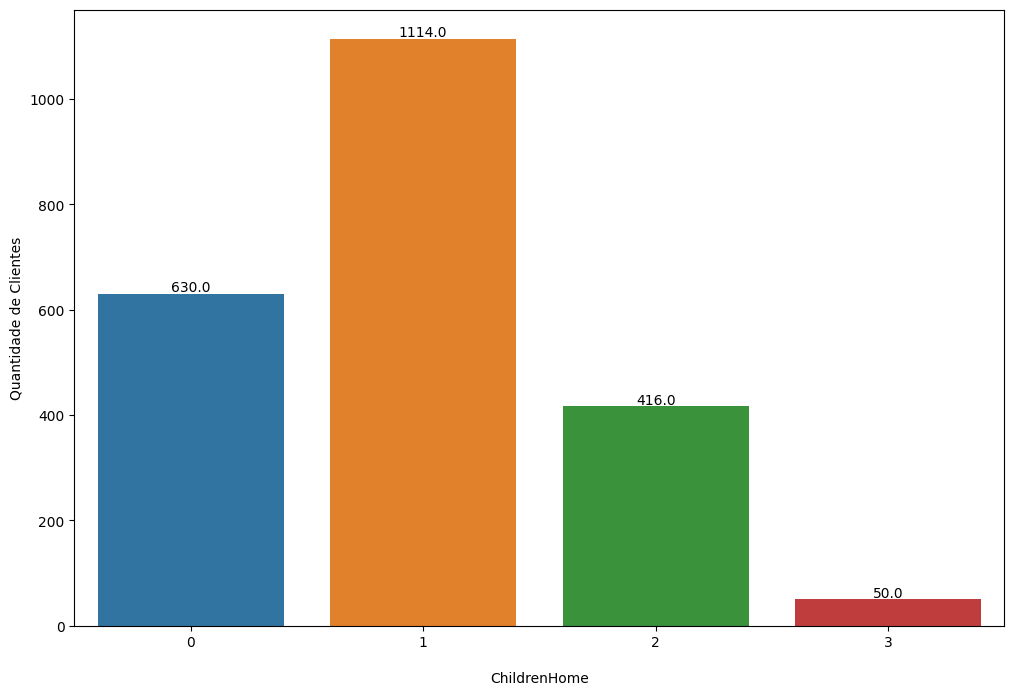

In [31]:
plot_cat(people, 'ChildrenHome')

In [32]:
people.drop(columns=['Kidhome', 'Teenhome'], inplace=True)

In [33]:
people.head()

,ID,Year_Birth,Education,Income,Dt_Customer,Recency,Complain,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome
0,5524,1957,2,58138.0,2012-09-04,58,0,0,1,0,0,0
1,2174,1954,2,46344.0,2014-03-08,38,0,0,1,0,0,2
2,4141,1965,2,71613.0,2013-08-21,26,0,0,0,1,0,0
3,6182,1984,2,26646.0,2014-02-10,26,0,0,0,1,0,1
4,5324,1981,4,58293.0,2014-01-19,94,0,0,0,1,0,1


### 2.1.8 Dt_Customer

In [34]:
people.Dt_Customer.min()

Timestamp('2012-07-30 00:00:00')

In [35]:
people.Dt_Customer.max()

Timestamp('2014-06-29 00:00:00')

In [36]:
(people['Dt_Customer'] + pd.to_timedelta(people['Recency'], unit='d')).max()

Timestamp('2014-10-04 00:00:00')

In [37]:
people['LifeTime'] = (pd.to_datetime('2014-10-05') - people['Dt_Customer']).dt.days/30

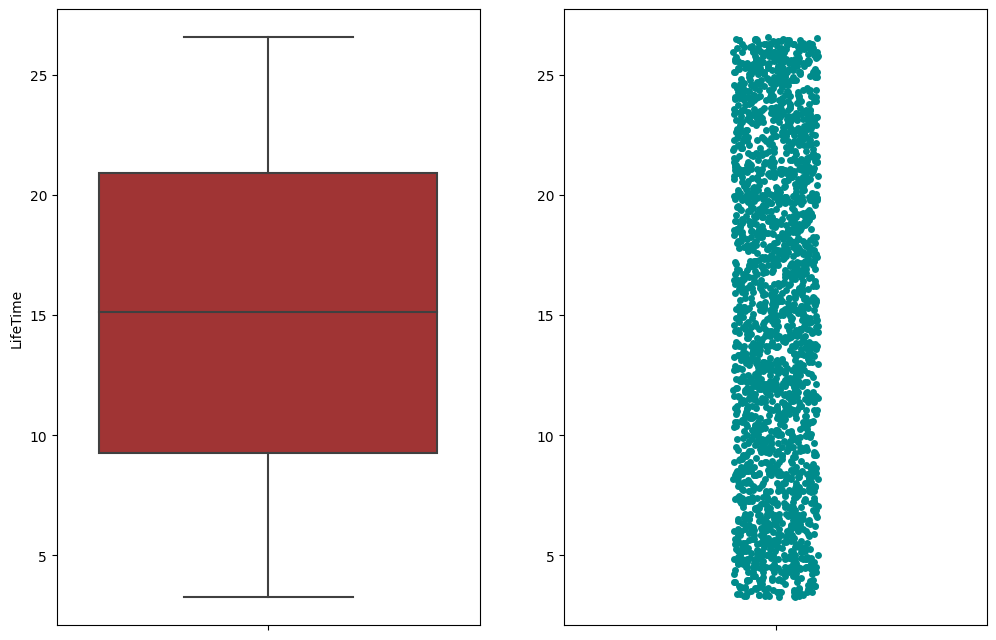

In [38]:
plot_num(people, 'LifeTime')

In [39]:
people.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Dt_Customer', 'Recency',
       'Complain', 'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime'],
      dtype='object')

### 2.1.9 Recency

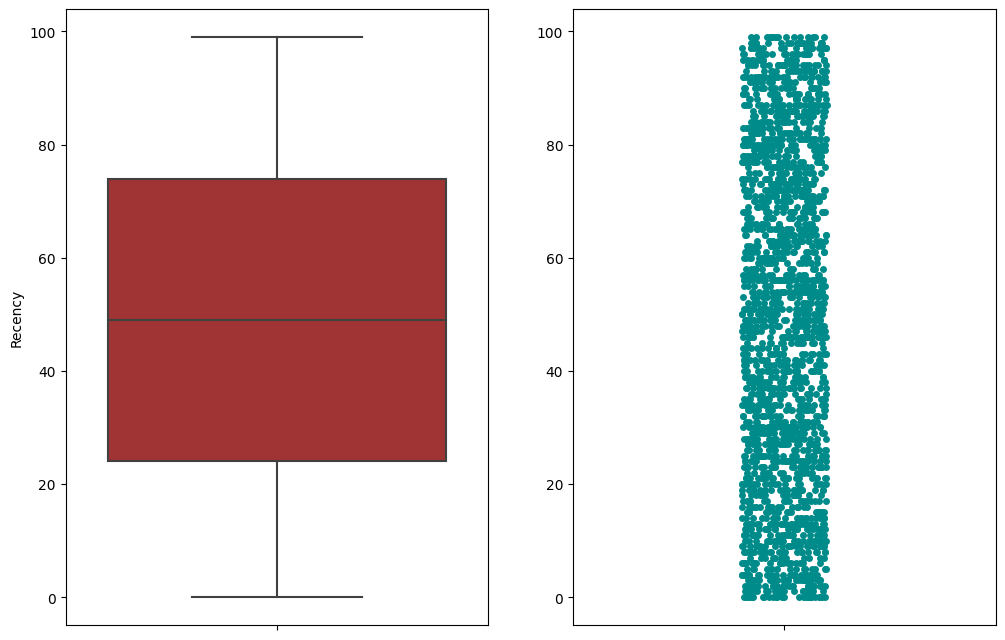

In [40]:
plot_num(people, 'Recency')

### 2.1.10 Complain

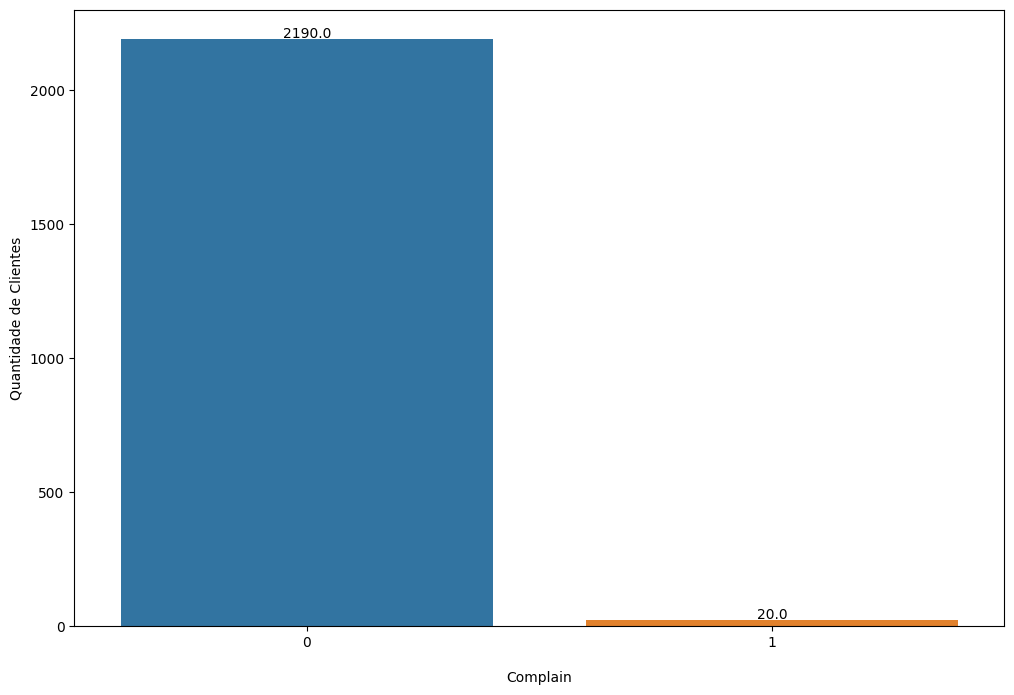

In [41]:
plot_cat(people, 'Complain')

In [42]:
people.drop(columns=['Complain'], inplace=True)

In [43]:
people.head()

,ID,Year_Birth,Education,Income,Dt_Customer,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime
0,5524,1957,2,58138.0,2012-09-04,58,0,1,0,0,0,25.366667
1,2174,1954,2,46344.0,2014-03-08,38,0,1,0,0,2,7.033333
2,4141,1965,2,71613.0,2013-08-21,26,0,0,1,0,0,13.666667
3,6182,1984,2,26646.0,2014-02-10,26,0,0,1,0,1,7.900000
4,5324,1981,4,58293.0,2014-01-19,94,0,0,1,0,1,8.633333


In [44]:
people.drop(columns=['Dt_Customer'], inplace=True)

In [45]:
people.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Recency',
       'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime'],
      dtype='object')

## 2.2 Products

In [46]:
products = df[['ID','MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

In [47]:
products.head()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,5524,635,88,546,172,88,88
1,2174,11,1,6,2,1,6
2,4141,426,49,127,111,21,42
3,6182,11,4,20,10,3,5
4,5324,173,43,118,46,27,15


In [48]:
show_null(products)

,#,% null,type
ID,0,0.0,int64
MntWines,0,0.0,int64
MntFruits,0,0.0,int64
MntMeatProducts,0,0.0,int64
MntFishProducts,0,0.0,int64
MntSweetProducts,0,0.0,int64
MntGoldProds,0,0.0,int64


##### MntWines

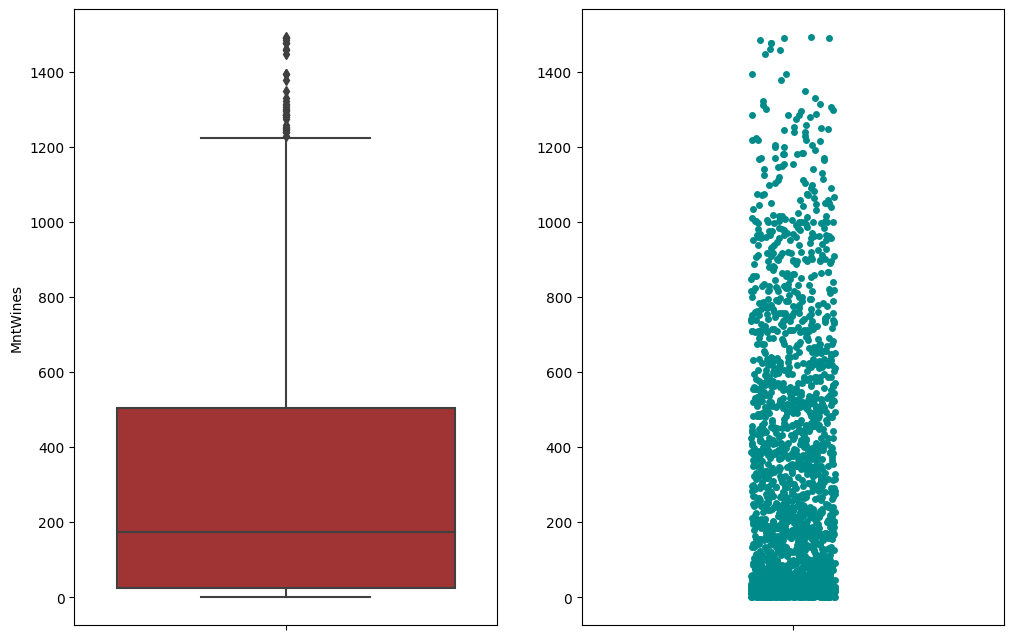

In [49]:
plot_num(products, 'MntWines')

##### MntFruits

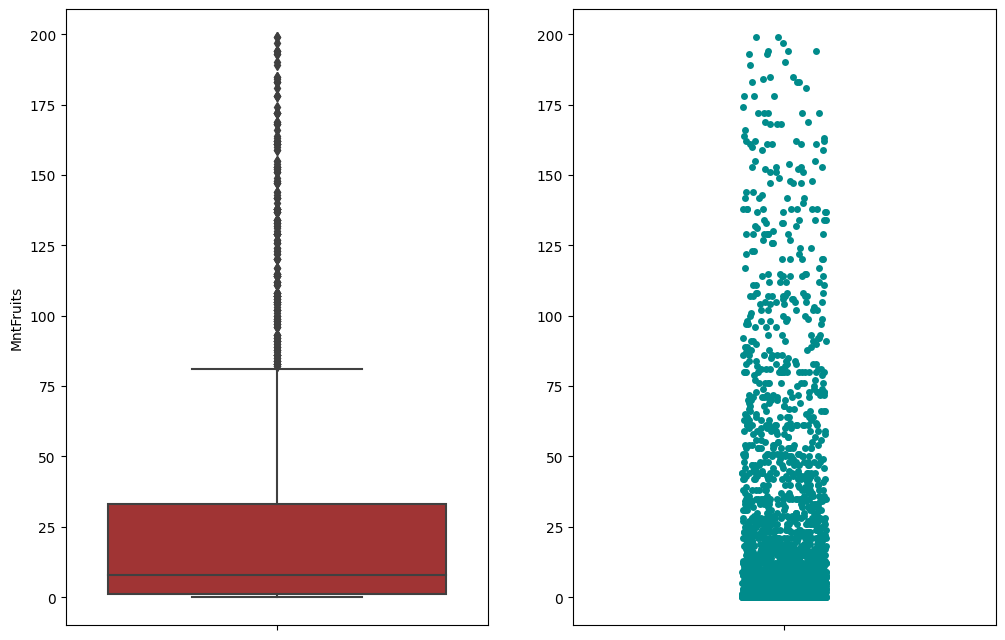

In [50]:
plot_num(products, 'MntFruits')

##### MntMeatProducts

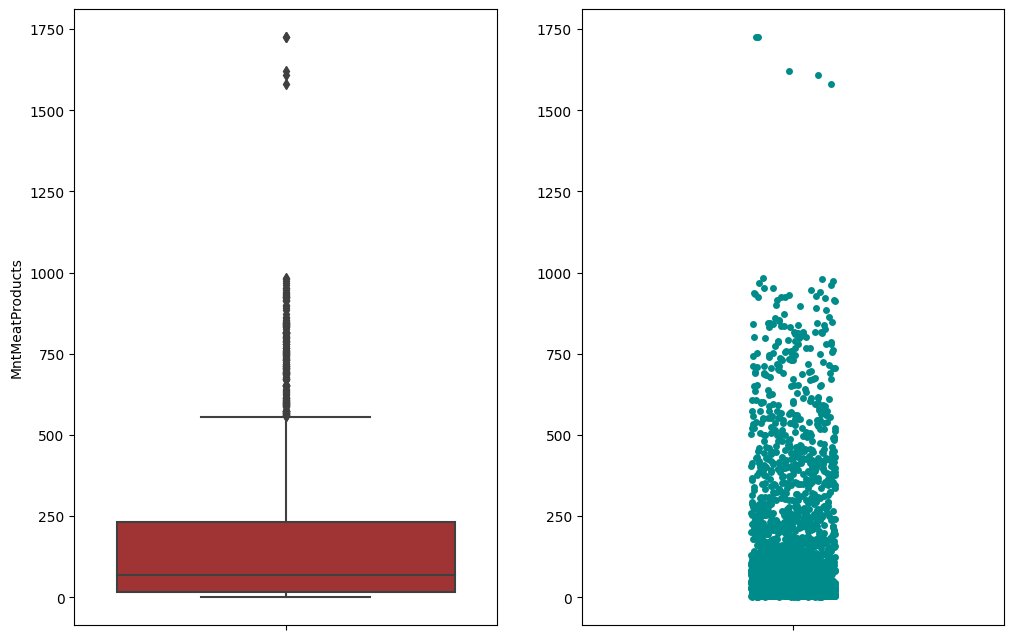

In [51]:
plot_num(products, 'MntMeatProducts')

##### MntFishProducts

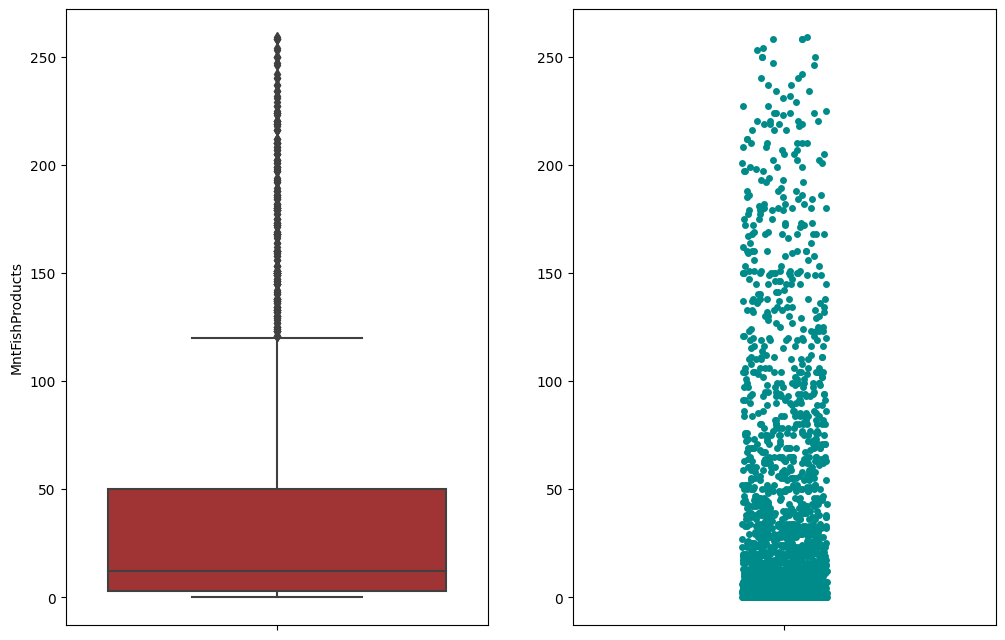

In [52]:
plot_num(products, 'MntFishProducts')

##### MntSweetProducts

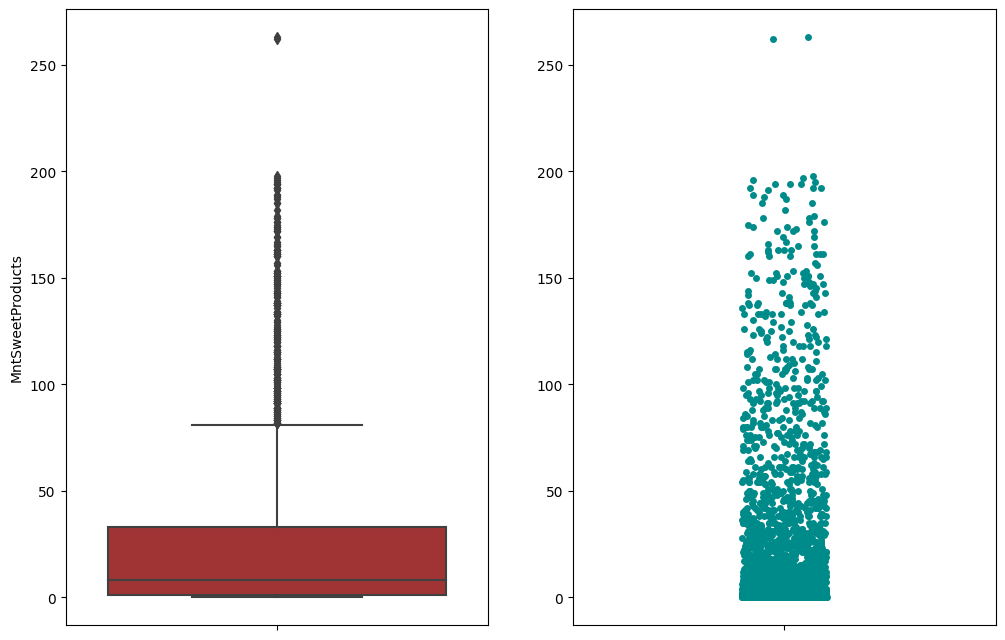

In [53]:
plot_num(products, 'MntSweetProducts')

##### MntGoldProds

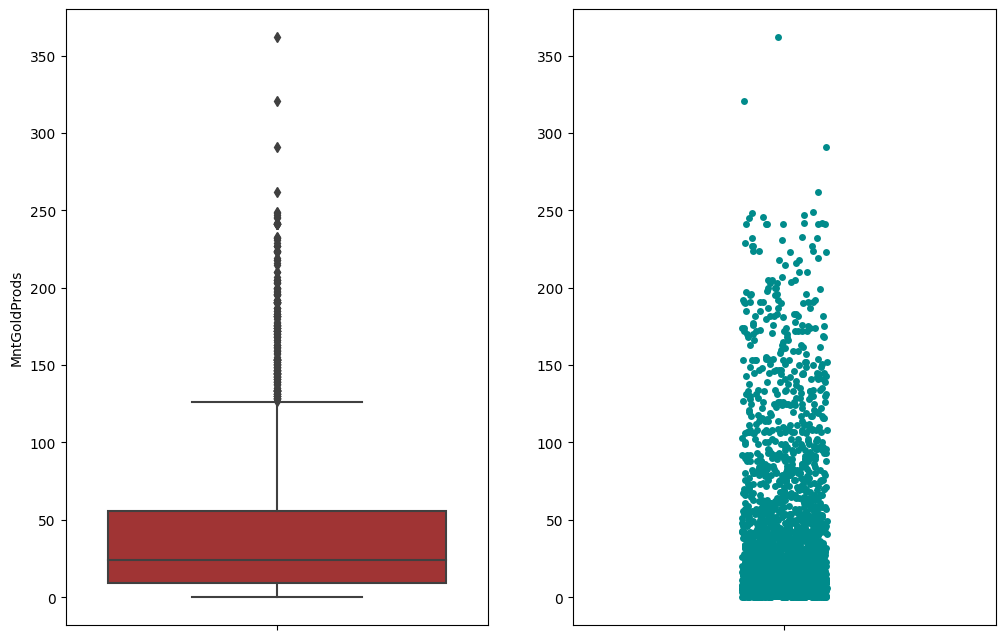

In [54]:
plot_num(products, 'MntGoldProds')

In [55]:
products['TotalAmountSpent'] = products.MntFishProducts + products.MntFruits + products.MntGoldProds \
+ products.MntMeatProducts + products.MntSweetProducts + products.MntWines

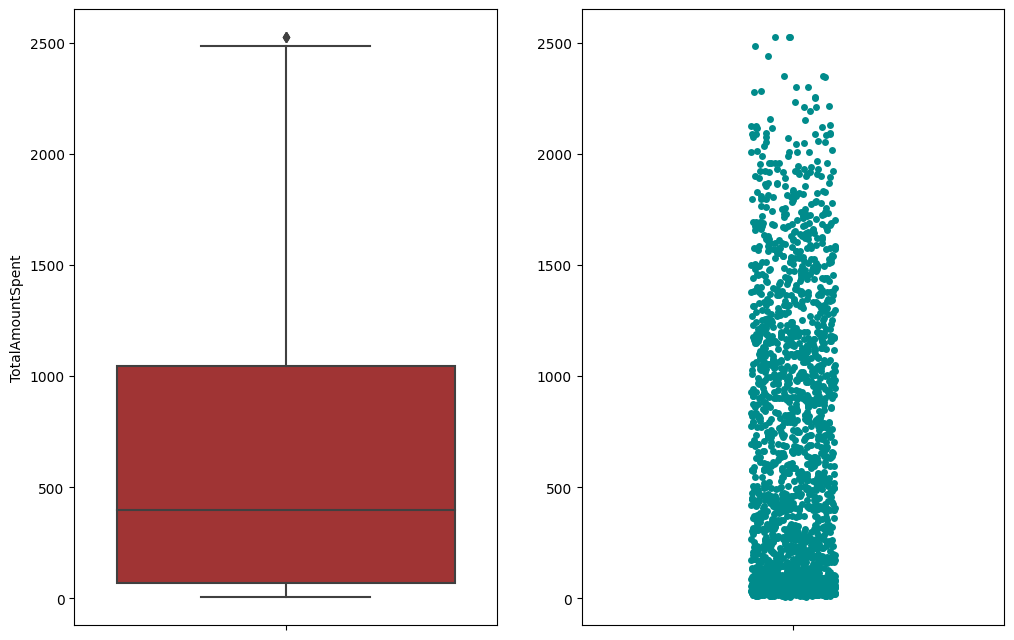

In [56]:
plot_num(products, 'TotalAmountSpent')

In [57]:
products.MntFishProducts = products.MntFishProducts/products['TotalAmountSpent']
products.MntFruits = products.MntFruits/products['TotalAmountSpent']
products.MntGoldProds = products.MntGoldProds/products['TotalAmountSpent']
products.MntMeatProducts = products.MntMeatProducts/products['TotalAmountSpent']
products.MntSweetProducts = products.MntSweetProducts/products['TotalAmountSpent']
products.MntWines = products.MntWines/products['TotalAmountSpent']

In [58]:
products.describe()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,0.458481,0.049505,0.249508,0.071532,0.050777,0.120196,605.798214
std,3246.662198,0.228411,0.055867,0.126633,0.077909,0.061184,0.108988,602.249288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,2828.250000,0.289506,0.008924,0.156250,0.012571,0.008621,0.038095,68.750000
50%,5458.500000,0.457482,0.029840,0.233447,0.048193,0.033333,0.086294,396.000000
75%,8427.750000,0.639143,0.070237,0.328227,0.104703,0.070411,0.169768,1045.500000
max,11191.000000,0.963303,0.445545,0.997110,0.590909,0.945848,0.894150,2525.000000


In [59]:
products.head()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent
0,5524,0.392703,0.054422,0.337662,0.106370,0.054422,0.054422,1617
1,2174,0.407407,0.037037,0.222222,0.074074,0.037037,0.222222,27
2,4141,0.548969,0.063144,0.163660,0.143041,0.027062,0.054124,776
3,6182,0.207547,0.075472,0.377358,0.188679,0.056604,0.094340,53
4,5324,0.409953,0.101896,0.279621,0.109005,0.063981,0.035545,422


#### Promotion

In [60]:
promotion = df[['ID','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 
                'AcceptedCmp5', 'Response']]

In [61]:
promotion.head()

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,5524,0,0,0,0,0,1
1,2174,0,0,0,0,0,0
2,4141,0,0,0,0,0,0
3,6182,0,0,0,0,0,0
4,5324,0,0,0,0,0,0


In [62]:
show_null(promotion)

,#,% null,type
ID,0,0.0,int64
AcceptedCmp1,0,0.0,int64
AcceptedCmp2,0,0.0,int64
AcceptedCmp3,0,0.0,int64
AcceptedCmp4,0,0.0,int64
AcceptedCmp5,0,0.0,int64
Response,0,0.0,int64


In [63]:
promotion.describe()

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,0.064286,0.013393,0.072768,0.074554,0.072768,0.149107
std,3246.662198,0.245316,0.114976,0.259813,0.262728,0.259813,0.356274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8427.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
promotion['AcceptedCmp'] = promotion.AcceptedCmp1 + promotion.AcceptedCmp2 + promotion.AcceptedCmp3 + promotion.AcceptedCmp4 + \
promotion.AcceptedCmp5 + promotion.Response

In [65]:
promotion['AcceptedCmp'].describe()

count    2240.000000
mean        0.446875
std         0.890543
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: AcceptedCmp, dtype: float64

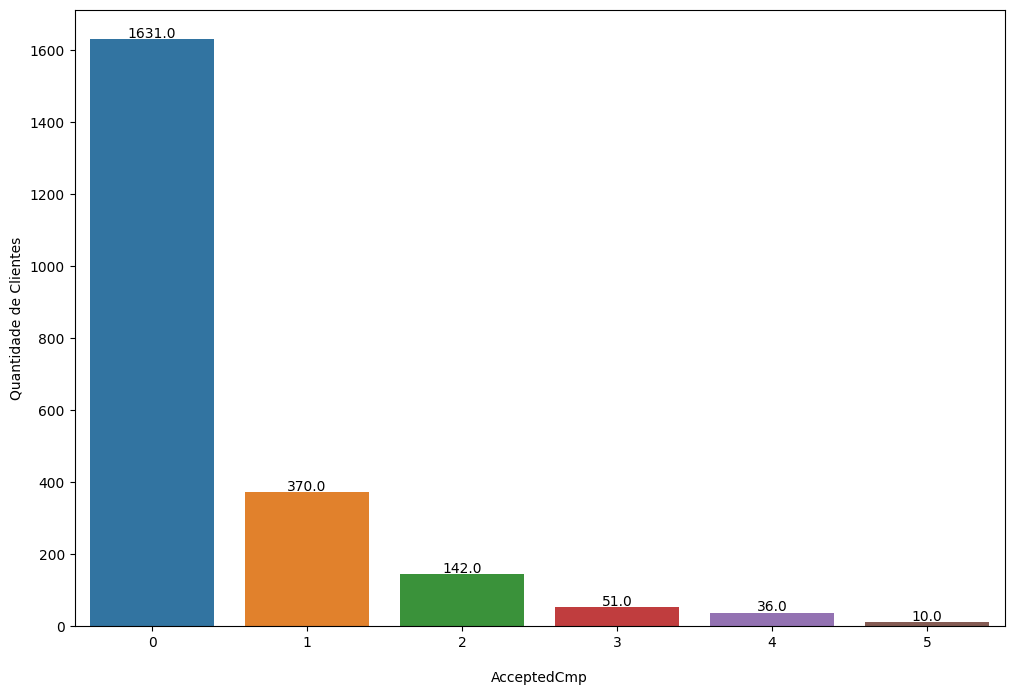

In [66]:
plot_cat(promotion, 'AcceptedCmp')

In [67]:
promotion = promotion[['ID', 'AcceptedCmp']]

In [68]:
promotion.head()

,ID,AcceptedCmp
0,5524,1
1,2174,0
2,4141,0
3,6182,0
4,5324,0


#### Place

In [69]:
place = df[['ID','NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth']]

In [70]:
place.head()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth
0,5524,8,10,4,3,7
1,2174,1,1,2,2,5
2,4141,8,2,10,1,4
3,6182,2,0,4,2,6
4,5324,5,3,6,5,5


In [71]:
show_null(place)

,#,% null,type
ID,0,0.0,int64
NumWebPurchases,0,0.0,int64
NumCatalogPurchases,0,0.0,int64
NumStorePurchases,0,0.0,int64
NumDealsPurchases,0,0.0,int64
NumWebVisitsMonth,0,0.0,int64


In [72]:
place['TotalPurchases'] = place.NumWebPurchases + place.NumCatalogPurchases + place.NumStorePurchases

In [73]:
place.describe()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,4.084821,2.662054,5.790179,2.325000,5.316518,12.537054
std,3246.662198,2.778714,2.923101,3.250958,1.932238,2.426645,7.205741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,2.000000,0.000000,3.000000,1.000000,3.000000,6.000000
50%,5458.500000,4.000000,2.000000,5.000000,2.000000,6.000000,12.000000
75%,8427.750000,6.000000,4.000000,8.000000,3.000000,7.000000,18.000000
max,11191.000000,27.000000,28.000000,13.000000,15.000000,20.000000,32.000000


In [74]:
place[place.TotalPurchases == 0]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
655,5555,0,0,0,0,0,0
981,3955,0,0,0,0,14,0
1245,6862,0,0,0,15,20,0
1524,11110,0,0,0,0,14,0
1846,9931,0,0,0,15,19,0
2132,11181,0,0,0,0,0,0


In [75]:
place = place[place['TotalPurchases']>0]

In [76]:
place['NumWebPurchases'] = place['NumWebPurchases']/place['TotalPurchases']
place['NumCatalogPurchases'] = place['NumCatalogPurchases']/place['TotalPurchases']
place['NumStorePurchases'] = place['NumStorePurchases']/place['TotalPurchases']
place['NumDealsPurchases'] = place['NumDealsPurchases']/place['TotalPurchases']

In [77]:
place.describe()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000
mean,5585.427037,0.329874,0.164809,0.505317,0.247963,5.300806,12.570725
std,3245.168172,0.121858,0.140668,0.149485,0.356679,2.372957,7.186011
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2817.750000,0.250000,0.000000,0.401852,0.083333,3.000000,6.000000
50%,5453.500000,0.333333,0.150000,0.500000,0.200000,6.000000,12.000000
75%,8419.500000,0.400000,0.250000,0.600000,0.333333,7.000000,18.000000
max,11191.000000,1.000000,1.000000,1.000000,15.000000,20.000000,32.000000


In [78]:
place[place.NumDealsPurchases > 1]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
1042,10749,0.0,1.0,0.0,15.0,19,1


In [79]:
place = place[place['NumDealsPurchases']<=1]

##### NumWebPurchases

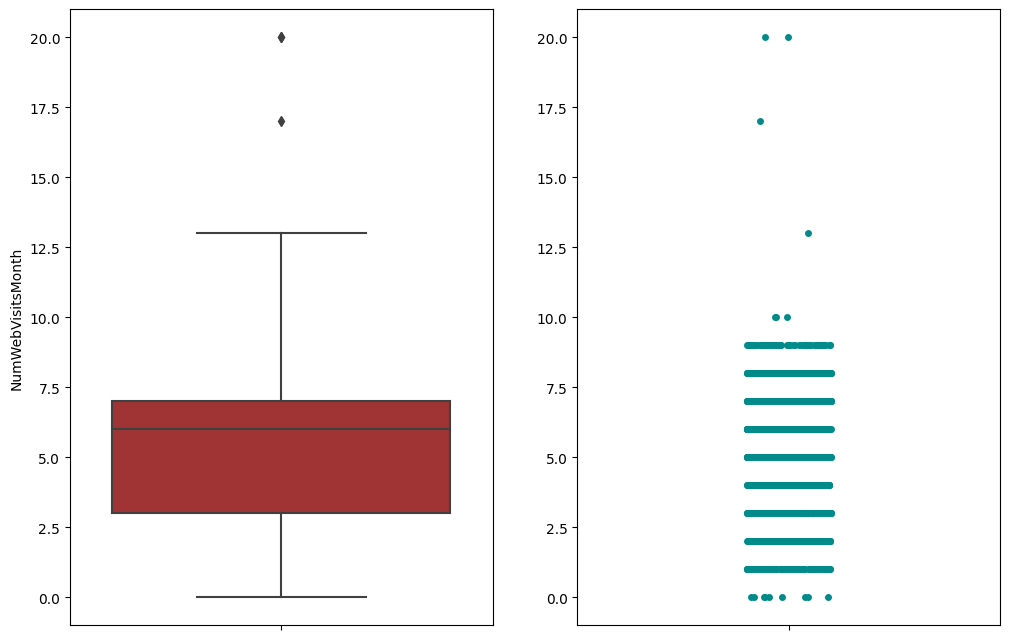

In [80]:
plot_num(place, 'NumWebVisitsMonth')

### Juntando Dados

In [81]:
df_lista = [people, products, promotion, place]

In [82]:
df_final = reduce(lambda df1, df2: pd.merge(df1, df2, on='ID'), df_lista)

In [83]:
df_final.shape

(2203, 25)

In [84]:
df_final.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Recency',
       'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'TotalAmountSpent', 'AcceptedCmp', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'TotalPurchases'],
      dtype='object')

In [85]:
df_final.drop(columns=['ID'], inplace=True)

### Normalização

In [86]:
def scaler(df):
    df2 = df.copy()
    for column in df2:
        minimo = df2[column].min()
        maximo = df2[column].max()
        df2[column] = (df[column] - minimo)/(maximo - minimo)
    return df2

In [87]:
scaled_df = scaler(df_final)

In [88]:
scaled_df.describe()

,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime,...,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,...,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000
mean,0.516179,0.615070,0.309517,0.494858,0.103495,0.214707,0.647299,0.034498,0.316689,0.506590,...,0.053607,0.134151,0.238604,0.089877,0.330002,0.164580,0.505419,0.241032,0.265138,0.374255
std,0.208790,0.251205,0.132629,0.292626,0.304674,0.410712,0.477919,0.182547,0.249584,0.289392,...,0.064434,0.121894,0.239412,0.178555,0.120862,0.139301,0.148665,0.172198,0.117599,0.231731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339286,0.500000,0.205796,0.242424,0.000000,0.000000,0.000000,0.000000,0.000000,0.258941,...,0.009126,0.042521,0.024235,0.000000,0.250000,0.000000,0.400000,0.083333,0.150000,0.161290
50%,0.535714,0.500000,0.305883,0.494949,0.000000,0.000000,1.000000,0.000000,0.333333,0.509299,...,0.034950,0.094632,0.154946,0.000000,0.333333,0.150000,0.500000,0.200000,0.300000,0.354839
75%,0.660714,0.750000,0.412801,0.747475,0.000000,0.000000,1.000000,0.000000,0.333333,0.756795,...,0.074329,0.189881,0.413190,0.200000,0.400000,0.250000,0.600000,0.333333,0.350000,0.580645
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Método de Elbow

In [89]:
inertia = []
num_clusters = range(1, 14)

for k in num_clusters:
    Model = KMeans(n_clusters=k)
    Model.fit(scaled_df)
    inertia.append(Model.inertia_)

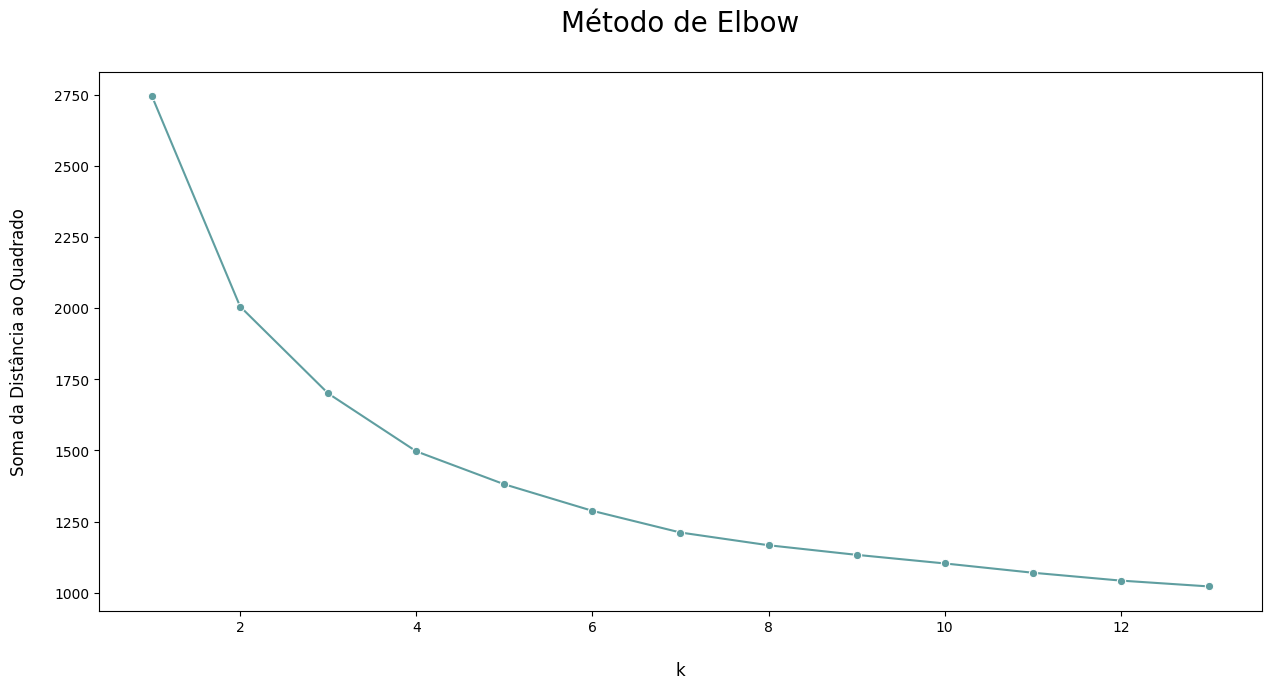

In [90]:
plt.figure(figsize=(15,7))
sns.lineplot(x=num_clusters, y=inertia, color='cadetblue', marker='o')
plt.xlabel('\nk', size=12)
plt.ylabel('Soma da Distância ao Quadrado\n', size=12)
plt.title('Método de Elbow\n', size=20)
plt.show()

### Alocação de Pesos

In [91]:
scaled_df.TotalAmountSpent = 8*scaled_df.TotalAmountSpent
scaled_df.TotalPurchases = 6*scaled_df.TotalPurchases
scaled_df.Recency = 4*scaled_df.Recency
scaled_df.NumWebVisitsMonth = 4*scaled_df.NumWebVisitsMonth
scaled_df.Income = 4*scaled_df.Income
scaled_df.LifeTime = 4*scaled_df.LifeTime
scaled_df.Year_Birth = 2*scaled_df.Year_Birth
scaled_df.ChildrenHome = 2*scaled_df.ChildrenHome
scaled_df.Education = 2*scaled_df.Education

In [92]:
scaled_df.columns

Index(['Year_Birth', 'Education', 'Income', 'Recency',
       'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'TotalAmountSpent', 'AcceptedCmp', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'TotalPurchases'],
      dtype='object')

In [93]:
scaled_df.describe()

,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime,...,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,...,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000
mean,1.032358,1.230141,1.238068,1.979431,0.103495,0.214707,0.647299,0.034498,0.633379,2.026362,...,0.053607,0.134151,1.908833,0.089877,0.330002,0.164580,0.505419,0.241032,1.060554,2.245530
std,0.417580,0.502410,0.530515,1.170504,0.304674,0.410712,0.477919,0.182547,0.499168,1.157569,...,0.064434,0.121894,1.915298,0.178555,0.120862,0.139301,0.148665,0.172198,0.470396,1.390384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.678571,1.000000,0.823182,0.969697,0.000000,0.000000,0.000000,0.000000,0.000000,1.035765,...,0.009126,0.042521,0.193882,0.000000,0.250000,0.000000,0.400000,0.083333,0.600000,0.967742
50%,1.071429,1.000000,1.223532,1.979798,0.000000,0.000000,1.000000,0.000000,0.666667,2.037196,...,0.034950,0.094632,1.239571,0.000000,0.333333,0.150000,0.500000,0.200000,1.200000,2.129032
75%,1.321429,1.500000,1.651204,2.989899,0.000000,0.000000,1.000000,0.000000,0.666667,3.027182,...,0.074329,0.189881,3.305522,0.200000,0.400000,0.250000,0.600000,0.333333,1.400000,3.483871
max,2.000000,2.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,...,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,6.000000


### Kmeans

In [94]:
Model = KMeans(n_clusters=4)

In [95]:
clusters = Model.fit_predict(scaled_df)

In [96]:
clusters

array([0, 3, 2, ..., 2, 2, 3])

In [97]:
df_final['cluster'] = clusters

In [98]:
df_final

,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime,...,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases,cluster
0,1957,2,58138.0,58,0,1,0,0,0,25.366667,...,0.054422,1617,1,0.363636,0.454545,0.181818,0.136364,7,22,0
1,1954,2,46344.0,38,0,1,0,0,2,7.033333,...,0.222222,27,0,0.250000,0.250000,0.500000,0.500000,5,4,3
2,1965,2,71613.0,26,0,0,1,0,0,13.666667,...,0.054124,776,0,0.400000,0.100000,0.500000,0.050000,4,20,2
3,1984,2,26646.0,26,0,0,1,0,1,7.900000,...,0.094340,53,0,0.333333,0.000000,0.666667,0.333333,6,6,3
4,1981,4,58293.0,94,0,0,1,0,1,8.633333,...,0.035545,422,0,0.357143,0.214286,0.428571,0.357143,5,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,1967,2,61223.0,46,0,0,1,0,1,15.966667,...,0.184191,1341,0,0.562500,0.187500,0.250000,0.125000,5,16,0
2199,1946,4,64014.0,56,0,0,1,0,3,3.900000,...,0.018018,444,1,0.533333,0.133333,0.333333,0.466667,7,15,2
2200,1981,2,56981.0,91,1,0,0,0,0,8.433333,...,0.019339,1241,1,0.111111,0.166667,0.722222,0.055556,6,18,2
2201,1956,3,69245.0,8,0,0,1,0,1,8.466667,...,0.072361,843,0,0.285714,0.238095,0.476190,0.095238,3,21,2


#### Salvando o modelo

In [99]:
# save the model to disk
filename = 'modelo_finalizado.sav'
pickle.dump(Model, open(filename, 'wb'))

In [100]:
# load the model from disk
Model = pickle.load(open(filename, 'rb'))

### Análise dos Clusters

In [101]:
df_final.cluster.value_counts().sort_values(ascending=True)

0    410
1    568
3    588
2    637
Name: cluster, dtype: int64

In [102]:
df_final.groupby('cluster').mean()

,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime,...,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
cluster,,,,,,,,,,,,,,,,,,,,,
0,1968.675610,2.578049,77234.939024,51.060976,0.104878,0.248780,0.612195,0.034146,0.297561,17.102195,...,0.042795,0.051138,1613.965854,1.248780,0.276633,0.309600,0.413767,0.082968,3.473171,20.353659
1,1970.096831,2.320423,36556.424296,74.721831,0.103873,0.214789,0.660211,0.021127,1.279930,14.519073,...,0.057597,0.165613,131.633803,0.123239,0.349958,0.089438,0.560604,0.346875,6.376761,6.744718
2,1965.857143,2.576138,63644.784929,48.100471,0.109890,0.182104,0.656201,0.051805,0.830455,15.215646,...,0.047542,0.082165,831.174254,0.398744,0.331477,0.214871,0.453651,0.160858,4.544741,18.381476
3,1971.219388,2.387755,36535.823129,23.656463,0.095238,0.226190,0.649660,0.028912,1.215986,14.028231,...,0.052987,0.164760,127.074830,0.261905,0.346338,0.081563,0.572099,0.335857,6.362245,6.593537


In [103]:
pd.set_option('display.max_columns', None)

In [104]:
df_final.groupby('cluster').mean().sort_values('TotalPurchases', ascending=False)

,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,1968.675610,2.578049,77234.939024,51.060976,0.104878,0.248780,0.612195,0.034146,0.297561,17.102195,0.497906,0.040283,0.308821,0.059056,0.042795,0.051138,1613.965854,1.248780,0.276633,0.309600,0.413767,0.082968,3.473171,20.353659
2,1965.857143,2.576138,63644.784929,48.100471,0.109890,0.182104,0.656201,0.051805,0.830455,15.215646,0.526618,0.045843,0.234614,0.063218,0.047542,0.082165,831.174254,0.398744,0.331477,0.214871,0.453651,0.160858,4.544741,18.381476
1,1970.096831,2.320423,36556.424296,74.721831,0.103873,0.214789,0.660211,0.021127,1.279930,14.519073,0.397451,0.054050,0.246382,0.078906,0.057597,0.165613,131.633803,0.123239,0.349958,0.089438,0.560604,0.346875,6.376761,6.744718
3,1971.219388,2.387755,36535.823129,23.656463,0.095238,0.226190,0.649660,0.028912,1.215986,14.028231,0.420320,0.054363,0.225893,0.081677,0.052987,0.164760,127.074830,0.261905,0.346338,0.081563,0.572099,0.335857,6.362245,6.593537


Cluster 3:
    Grupo que possui maior média de compras. 

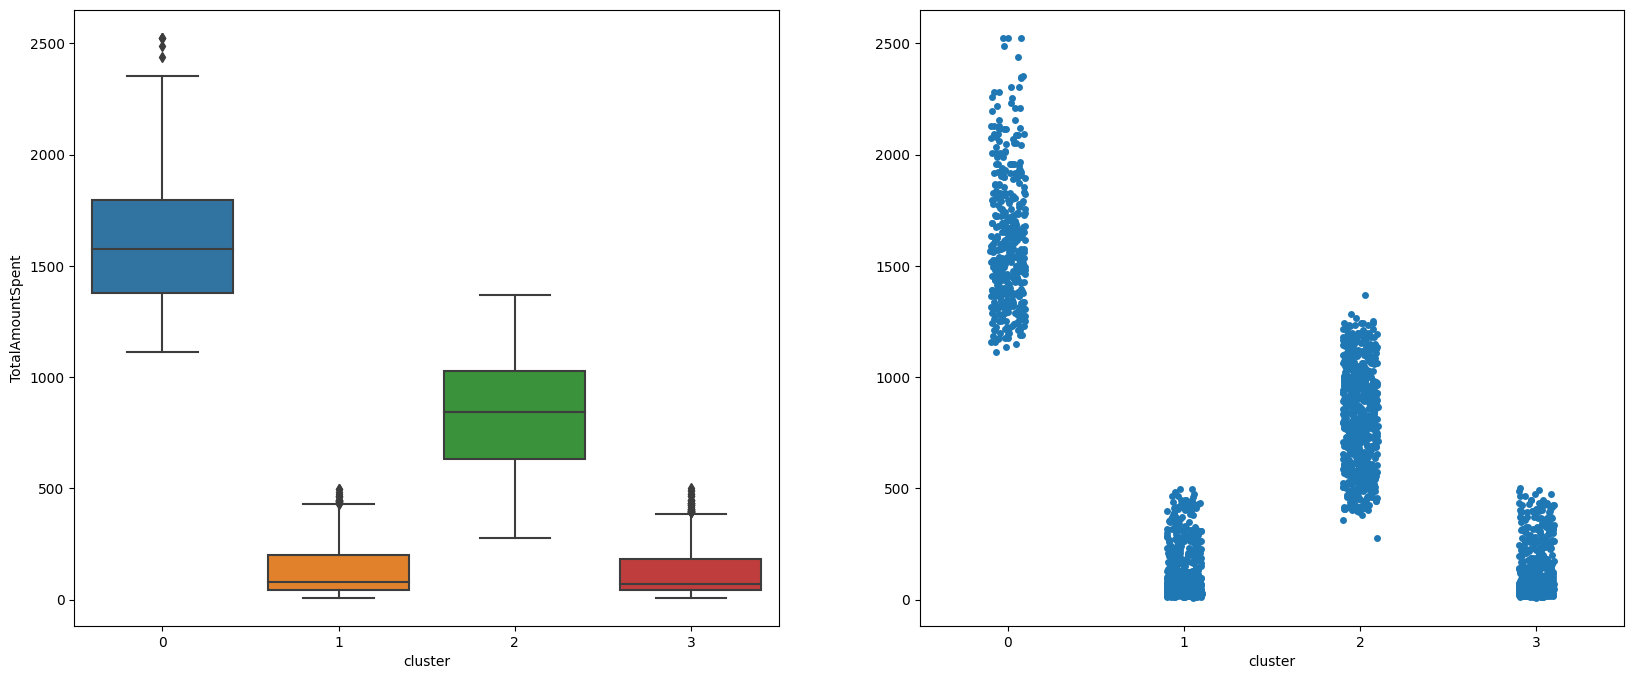

In [105]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='TotalAmountSpent', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('TotalAmountSpent')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='TotalAmountSpent', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

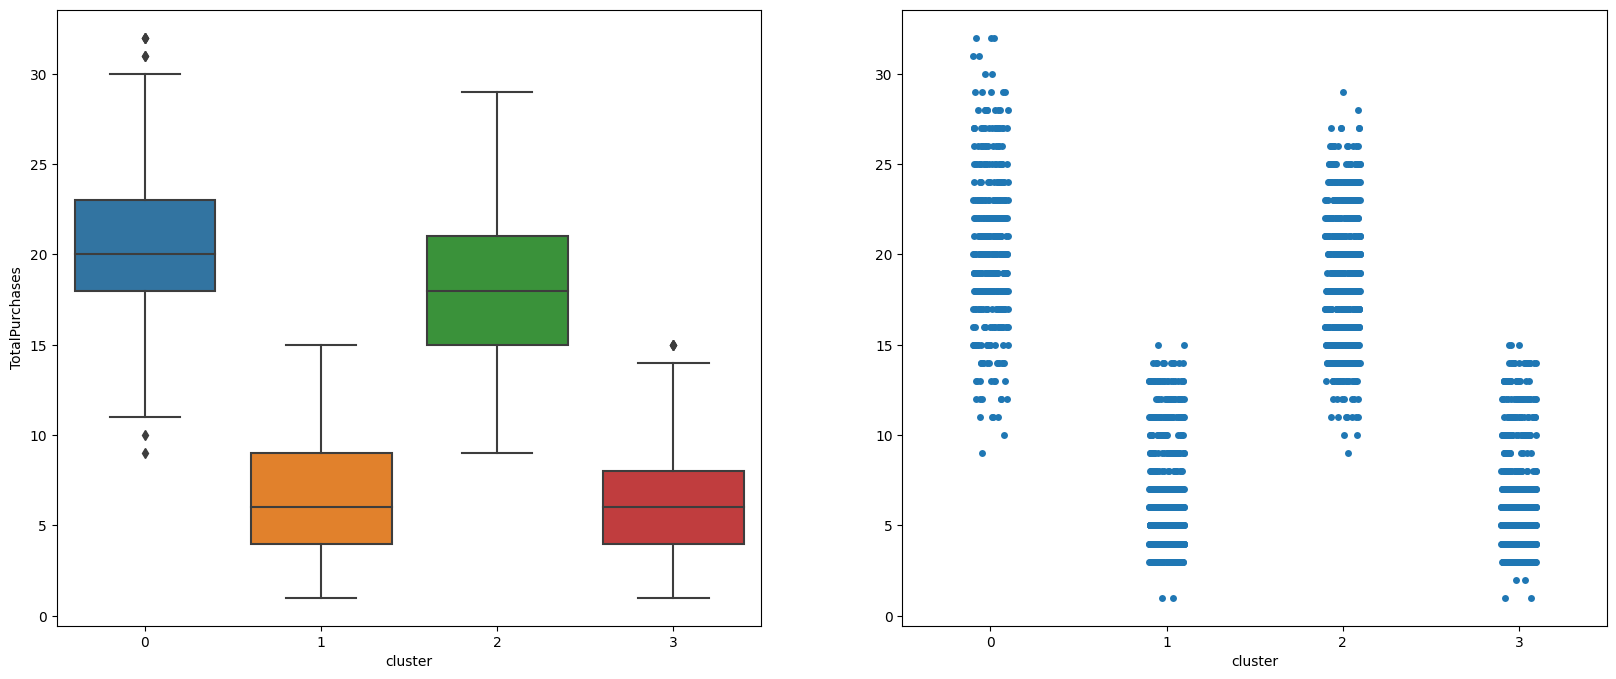

In [106]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='TotalPurchases', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('TotalPurchases')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='TotalPurchases', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

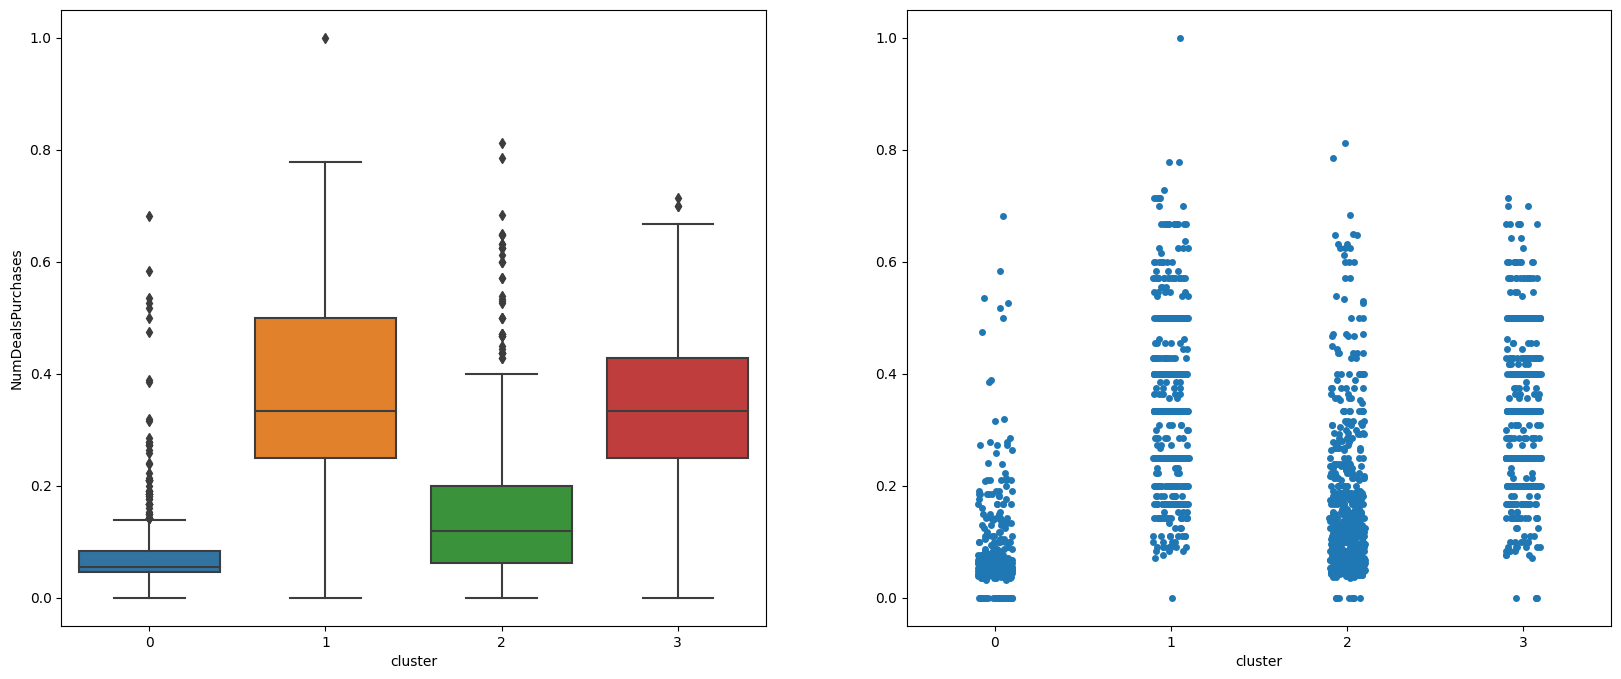

In [107]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='NumDealsPurchases', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('NumDealsPurchases')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='NumDealsPurchases', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

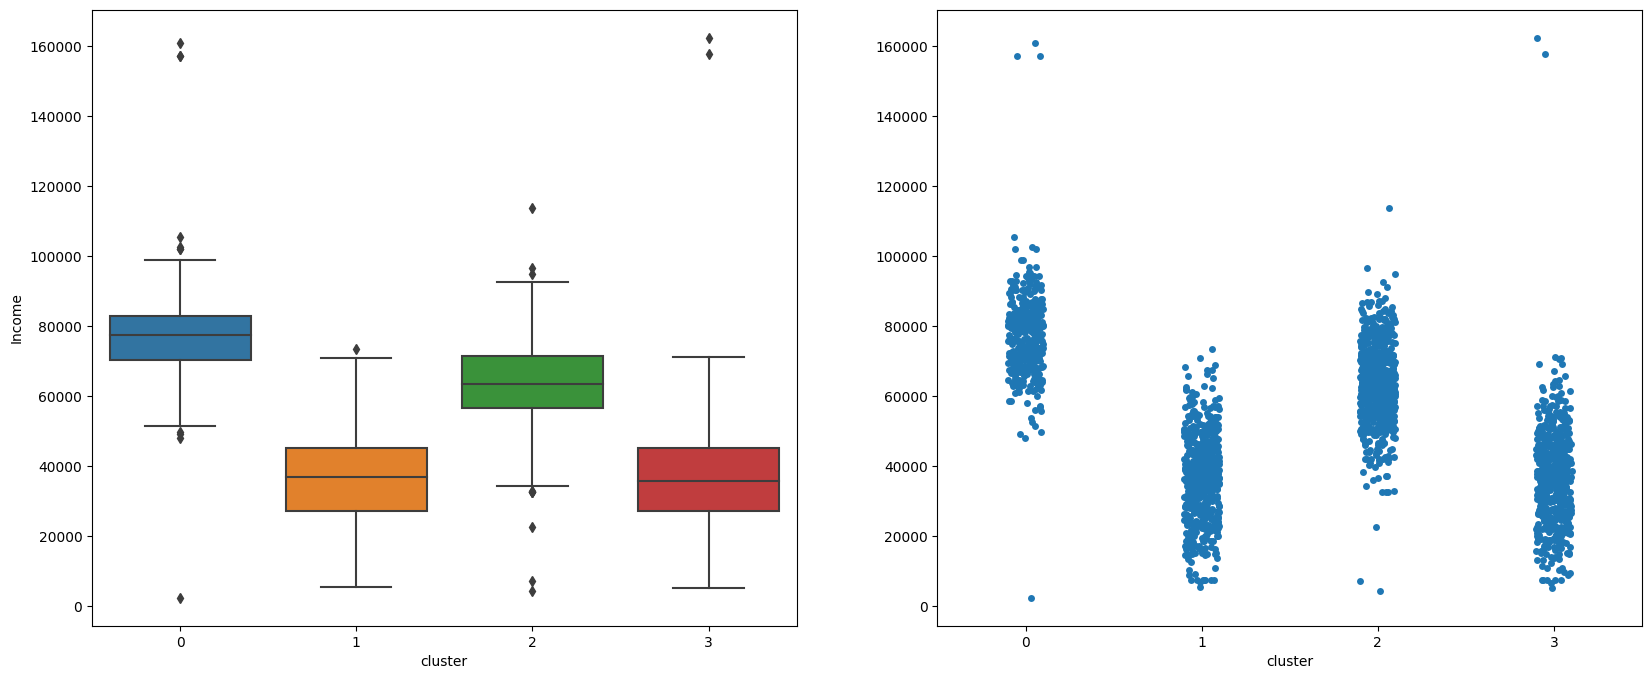

In [108]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='Income', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('Income')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='Income', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

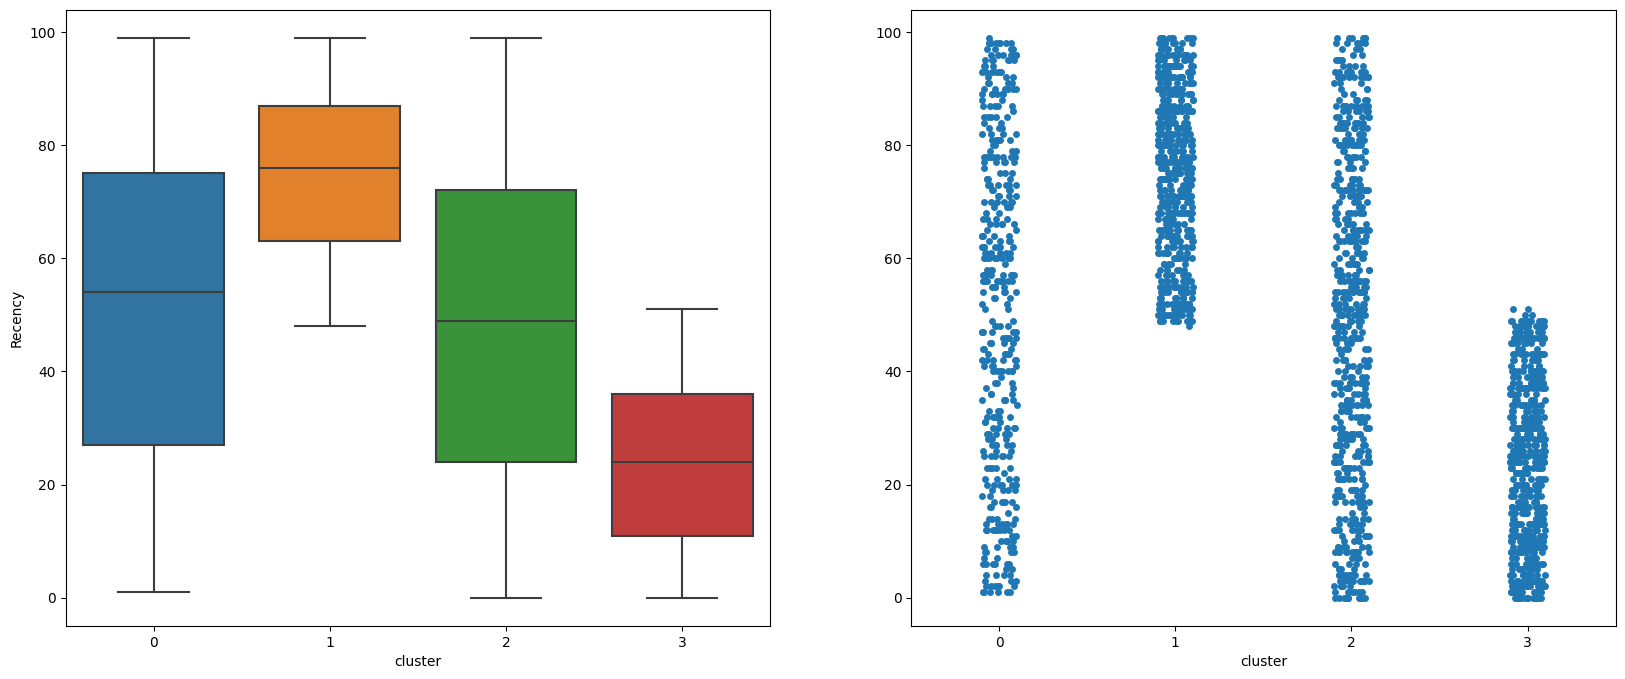

In [109]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='Recency', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('Recency')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='Recency', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

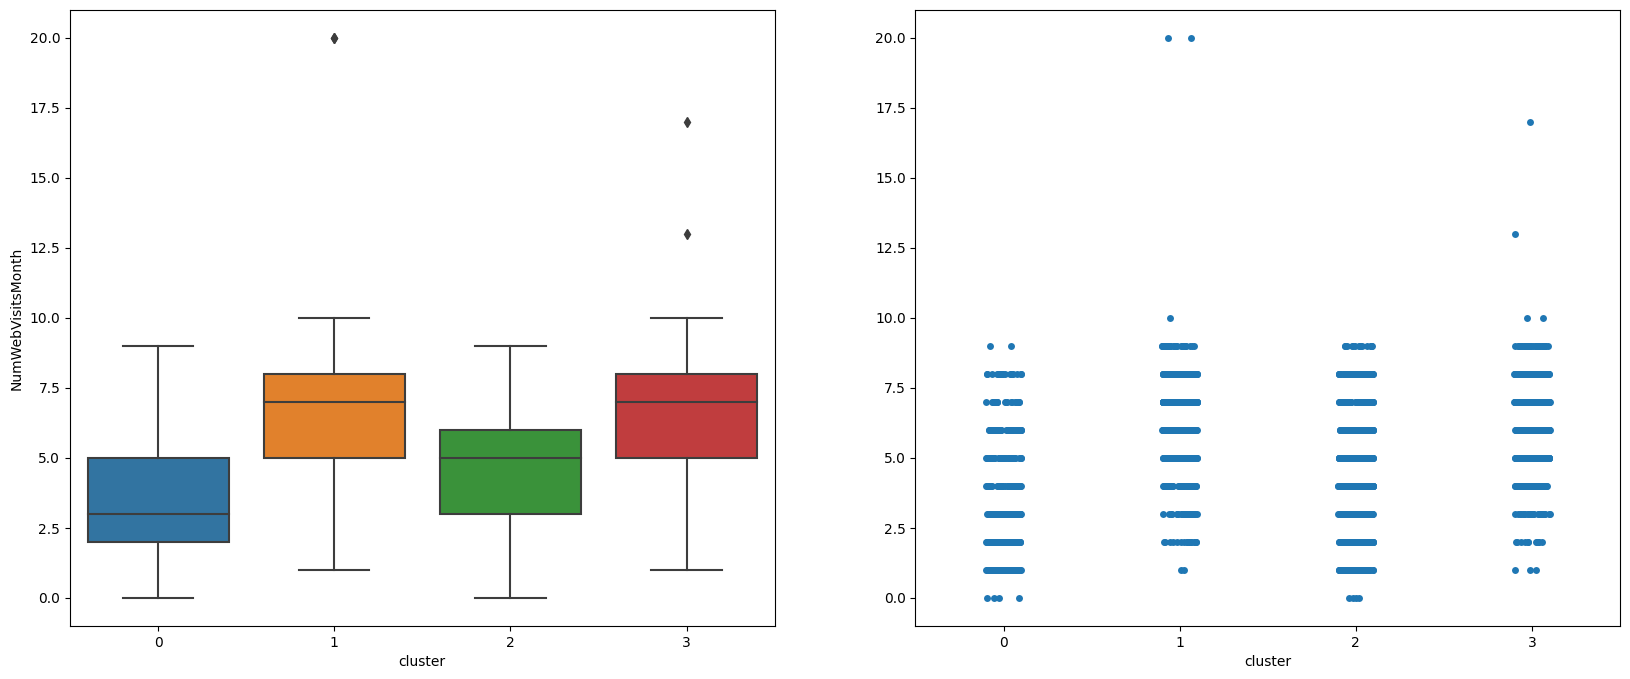

In [110]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='NumWebVisitsMonth', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('NumWebVisitsMonth')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='NumWebVisitsMonth', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()